In [1]:
import torch
import os
import numpy as np
import matplotlib.pyplot as plt
import copy
import GPUtil
from collections import defaultdict
from analysis import utils as au
from analysis import plotting
from data import utils as du
from data import se3_diffuser
from data import so3_diffuser
from model import loss
from model import reverse_se3_diffusion
import tree
from data import rosetta_data_loader
from experiments import train_se3_diffusion
from openfold.utils import rigid_utils as ru
from scipy.spatial.transform import Rotation
from openfold.utils.rigid_utils import Rigid

from omegaconf import OmegaConf
import importlib

# Enable logging
import logging
import sys
date_strftime_format = "%Y-%m-%y %H:%M:%S"
logging.basicConfig(stream=sys.stdout, level=logging.INFO, format="%(asctime)s %(message)s", datefmt=date_strftime_format)

INFO: Using numpy backend


In [2]:
importlib.reload(rosetta_data_loader)
importlib.reload(se3_diffuser)
importlib.reload(reverse_se3_diffusion)
importlib.reload(so3_diffuser)
importlib.reload(du)
importlib.reload(train_se3_diffusion)

<module 'experiments.train_se3_diffusion' from '/data/rsg/chemistry/jyim/projects/protein_diffusion/experiments/train_se3_diffusion.py'>

In [3]:
# Load config.
conf = OmegaConf.load('../config/base.yaml')
# rocklin_conf = OmegaConf.load('../config/sanity_check_rocklin.yaml')
# debug_conf = OmegaConf.load('../config/debug.yaml')
# conf = OmegaConf.merge(conf, rocklin_conf)

# Redirect cache from notebook directory.
exp_conf = conf.experiment
exp_conf.ckpt_dir = None
exp_conf.num_loader_workers = 1
exp_conf.num_epoch = 10000
exp_conf.dist_mode = 'single'
exp_conf.use_wandb = False

data_conf = conf.data
data_conf.rosetta.max_examples = 1
data_conf.rosetta.max_len = 100
data_conf.rosetta.use_rocklin = True

diff_conf = conf.diffuser
diff_conf.diffuse_trans = True

model_conf = conf.model
model_conf.num_blocks = 1

# print(OmegaConf.to_yaml(conf))

In [4]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
chosen_gpu = ''.join(
    [str(x) for x in GPUtil.getAvailable(order='memory')])
os.environ["CUDA_VISIBLE_DEVICES"] = chosen_gpu

In [5]:
# Figure out data loading for PDB on rosetta
exp = train_se3_diffusion.Experiment(conf=conf)
train_loader, valid_loader = exp.create_rosetta_dataset(0, 1)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
exp._model = exp._model.to(device)

INFO: Number of model parameters 1251854
INFO: Checkpoint not being saved.


Using cached IGSO3.
Using R^3 VP-SDE


INFO: Training: 1 examples
INFO: Validation: 1 examples


## Training

In [6]:
num_epochs = 2
step = 0
epoch = 0
train_losses = defaultdict(list)
log_losses = defaultdict(list)
latest_aux_data = []
sampled_ts = []
def update_logs(x,y):
    for k in y:
        if 'loss' in k:
            x[k].append(y[k])
log_freq = 100

exp._model = exp._model.to(device)
exp._model.train()
while epoch < num_epochs:
    epoch += 1
    for train_features in train_loader:
        step += 1
        exp.step = step
        exp.num_epochs = epoch
        sampled_ts.append(train_features['t'])
        train_features = tree.map_structure(
            lambda x: x.to(device), train_features)
        _, aux_data = exp.update_fn(train_features)
        aux_data = tree.map_structure(du.move_to_np, aux_data)
        latest_aux_data.append(aux_data)
        update_logs(train_losses, aux_data)
        update_logs(log_losses, aux_data)
        if step == 1 or step % log_freq == 0:
            print_log = f'Step {step}: '
            for k,v in log_losses.items():
                print_log += f'{k}={np.mean(v):.4f} '
            print(print_log)
            log_losses = defaultdict(list)
            latest_aux_data = []

Step 1: total_loss=5.9515 rot_loss=3.0395 trans_loss=2.9120 


Text(0, 0.5, 'Total loss')

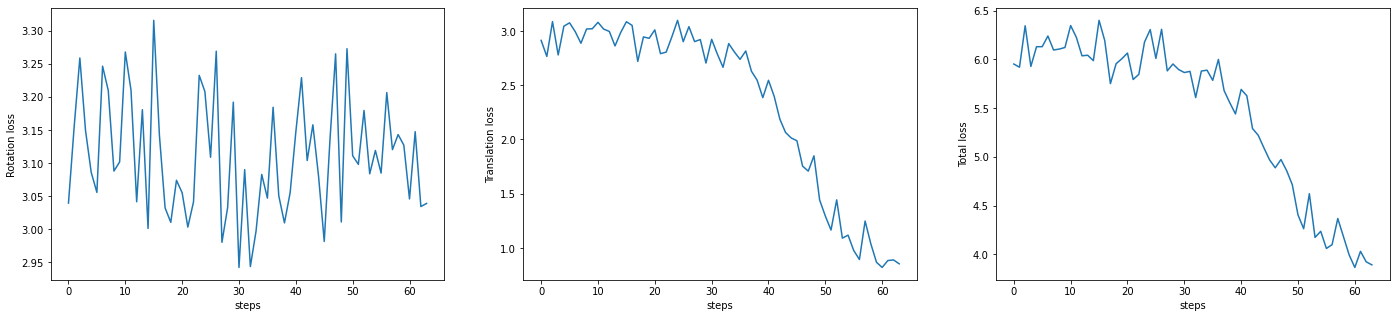

In [7]:
f, axes = plt.subplots(1, 3, figsize=[24, 5])

axes[0].plot(train_losses['rot_loss'])
axes[0].set_xlabel('steps')
axes[0].set_ylabel('Rotation loss')

axes[1].plot(train_losses['trans_loss'])
axes[1].set_xlabel('steps')
axes[1].set_ylabel('Translation loss')

axes[2].plot(train_losses['total_loss'])
axes[2].set_xlabel('steps')
axes[2].set_ylabel('Total loss')

## Equivariance test

In [8]:
# Sample data point to initializez.
data_iter = iter(train_loader)
raw_data_feats = next(data_iter)

In [9]:
b_idx = 0
data_raw = tree.map_structure(lambda x: x.to(device)[b_idx:b_idx+1], raw_data_feats)
res_mask = data_raw['res_mask'].bool()
data_raw['rigids_0'] = data_raw['rigids_0'][torch.where(res_mask)][None]
data_raw['atom_positions'] = data_raw['atom_positions'][torch.where(res_mask)][None]
data_raw['rigids_t'] = data_raw['rigids_0'][torch.where(res_mask)][None]
data_raw['res_mask'] = data_raw['res_mask'][torch.where(res_mask)][None]
data_raw['res_idx'] = data_raw['res_idx'][torch.where(res_mask)][None]
# gt_frames = Rigid.from_tensor_7(data_raw['rigids_0'])

In [28]:
data_perturbed = copy.deepcopy(data_raw)
atom_pos = du.move_to_np(data_raw['atom_positions'])
res_mask = du.move_to_np(data_raw['res_mask'])
rand_rot = Rotation.random().as_matrix()

# perturbed_atom_pos = np.einsum('ij,...i->...j', rand_rot, atom_pos) + 10.0
# perturbed_atom_pos = atom_pos + 10.0
# perturbed_atom_pos = np.einsum('ij,...i->...j', rand_rot, atom_pos)
perturbed_atom_pos = np.einsum('...i,ij->...j', atom_pos, rand_rot)
# perturbed_atom_pos = atom_pos @ rand_rot

perturbed_atom_pos *= res_mask[..., None, None]
perturbed_frames = du.rigid_frames_from_all_atom(
    torch.Tensor(perturbed_atom_pos[0]).to(device))
data_perturbed['rigids_0'] = perturbed_frames.to_tensor_7()[None]
data_perturbed['rigids_t'] = perturbed_frames.to_tensor_7()[None]

In [29]:
raw_frame = Rigid.from_tensor_7(data_raw['rigids_0'][0, 2])
perturbed_frame = Rigid.from_tensor_7(data_perturbed['rigids_0'][0, 2])

raw_rot = du.move_to_np(raw_frame.get_rots().get_rot_mats())
perturbed_rot = du.move_to_np(perturbed_frame.get_rots().get_rot_mats())

In [30]:
perturbed_rot

array([[ 0.58762264, -0.79761046,  0.13607693],
       [ 0.62892884,  0.55605257,  0.54337263],
       [-0.5090657 , -0.2337154 ,  0.8283894 ]], dtype=float32)

In [33]:
np.einsum('ij,jk->ik', raw_rot, rand_rot)

array([[ 0.62452477, -0.57161398, -0.53218988],
       [ 0.11712966, -0.60515929,  0.78744056],
       [-0.77217182, -0.55411137, -0.31098403]])

In [35]:
np.einsum('ji,jk->ik', raw_rot, rand_rot)

array([[ 0.58762276,  0.62892895, -0.50906555],
       [-0.79761045,  0.55605249, -0.23371555],
       [ 0.13607667,  0.54337263,  0.82838945]])

In [ ]:
def gramschmidt(A):
    """
    Applies the Gram-Schmidt method to A
    and returns Q and R, so Q*R = A.
    """
    R = np.zeros((A.shape[1], A.shape[1]))
    Q = np.zeros(A.shape)
    for k in range(0, A.shape[1]):
        R[k, k] = np.sqrt(np.dot(A[:, k], A[:, k]))
        Q[:, k] = A[:, k]/R[k, k]
        for j in range(k+1, A.shape[1]):
            R[k, j] = np.dot(Q[:, k], A[:, j])
            A[:, j] = A[:, j] - R[k, j]*Q[:, k]
    return Q, R

def main():
    """
    Prompts for n and generates a random matrix.
    """
    cols = input('give number of columns : ')
    rows = input('give number of rows : ')
    A = np.random.rand(rows, cols)
    print 'A = '
    print A
    Q, R = gramschmidt(A)
    print 'Q = '
    print Q
    print 'R = '
    print R
    print 'Q^T*Q = '
    print np.dot(Q.transpose(), Q)
    print 'Q*R ='
    print np.dot(Q, R)

main()

In [37]:
model_out = exp.model(data_raw)
model_out_perturbed = exp.model(data_perturbed)

trans_out = du.move_to_np(model_out['trans_score'][0])
trans_out_perturbed = du.move_to_np(model_out_perturbed['trans_score'][0])

rot_out = du.move_to_np(model_out['rot_score'][0])
rot_out_perturbed = du.move_to_np(model_out_perturbed['rot_score'][0])

In [42]:
local_trans_out = du.move_to_np(model_out['local_trans_score'][0])
local_trans_out_perturbed = du.move_to_np(model_out_perturbed['local_trans_score'][0])

In [43]:
local_trans_out[:3]

array([[ 0.27344036, -0.4461941 ,  0.2929207 ],
       [-0.18199039, -0.4491585 , -0.99151856],
       [ 0.07410327, -0.86156964, -0.5807015 ]], dtype=float32)

In [44]:
local_trans_out_perturbed[:3]

array([[ 0.27344036, -0.4461941 ,  0.2929207 ],
       [-0.18199116, -0.44915953, -0.9915182 ],
       [ 0.07410339, -0.8615695 , -0.5807014 ]], dtype=float32)

In [38]:
trans_out_perturbed[res_mask[0].astype(bool)][:5]

array([[ 0.28176194, -0.5073451 , -0.1512368 ],
       [ 0.45358074, -0.97639   ,  0.2426942 ],
       [ 0.6517216 , -0.74800944, -0.31740832],
       [ 0.6220806 , -0.8300474 , -0.28215963],
       [ 0.42710245, -0.45030817,  0.1895298 ]], dtype=float32)

In [39]:
np.einsum('ij,...i->...j', rand_rot, trans_out)[res_mask[0].astype(bool)][:5]

array([[ 0.28176188, -0.5073451 , -0.15123676],
       [ 0.45358179, -0.97638917,  0.24269489],
       [ 0.65172174, -0.74800954, -0.31740814],
       [ 0.6220803 , -0.83004751, -0.28215944],
       [ 0.42710228, -0.4503082 ,  0.18952994]])

In [40]:
rot_out[res_mask[0].astype(bool)][:5]

array([[-0.03287837, -0.03850828,  0.02004537],
       [-0.03650529, -0.03752586, -0.0341332 ],
       [-0.05683492, -0.05072467, -0.02597251],
       [-0.0406106 , -0.05337866, -0.00215833],
       [-0.02017541, -0.02120873, -0.00483539]], dtype=float32)

In [41]:
rot_out_perturbed[res_mask[0].astype(bool)][:5]

array([[-0.03287837, -0.03850828,  0.02004537],
       [-0.03650534, -0.03752593, -0.03413321],
       [-0.05683492, -0.05072467, -0.0259725 ],
       [-0.0406106 , -0.05337866, -0.00215833],
       [-0.02017541, -0.02120873, -0.00483539]], dtype=float32)

## Data visualization

In [ ]:
train_iter = iter(train_loader)
next_item = next(train_iter)
print(next_item['t'])

In [ ]:
# Rigid process function
scale_factor = conf.data.rosetta.scale_factor
bb_mask = next_item['res_mask'].bool()
def process_rigids(rigids, b_idx):
    np_rigids = du.move_to_np(rigids[b_idx][bb_mask[b_idx]])
    se3_vec = au.rigids_to_se3_vec(np_rigids, scale_factor=scale_factor)
    return np_rigids, se3_vec

In [ ]:
# Visualize example
rigids_t, noisy_se3_vec = process_rigids(next_item['rigids_t'], 0)
rigids_0, gt_se3_vec = process_rigids(next_item['rigids_0'], 0)


In [ ]:
ax_lim = 10
f, axes = plt.subplots(1, 2, figsize=[16, 8], subplot_kw=dict(projection="3d"))
plotting.plot_se3(gt_se3_vec, ax=axes[0], title='Initialization', ax_lim=ax_lim)
plotting.plot_se3(noisy_se3_vec, ax=axes[1], title='Sampled frame', ax_lim=ax_lim)

## Sampling

In [37]:
exp_diffuser = exp.diffuser

In [46]:
# Sample data point to initializez.
data_iter = iter(train_loader)
raw_data_feats = next(data_iter)

In [49]:
batch_idx = 1
data_feats = tree.map_structure(lambda x: x[batch_idx], raw_data_feats)
res_mask = data_feats['res_mask']
res_idx = data_feats['res_idx']
rigids_0 = data_feats['rigids_0']

num_res = res_mask.shape[0]
rigids_init = exp_diffuser.random_init(num_res).to_tensor_7()
rigids_init *= res_mask[:, None]
sample_feats = {
    'rigids_t': rigids_init,
    'res_mask': res_mask,
    'res_idx': res_idx,
    't': torch.tensor(exp_diffuser.num_t),
}
sample_feats = tree.map_structure(lambda x: x[None].to(device), sample_feats)

In [50]:
# Run reverse diffusion
reverse_steps = list(reversed(range(exp.diffuser.num_t)))
all_steps = [copy.deepcopy(sample_feats['rigids_t'])]
for t in reverse_steps[:-1]:
    sample_feats['t'] = (
        t * torch.ones_like(
            sample_feats['t'],
            device=device)).to(device)
    with torch.no_grad():
        model_out = exp.model(sample_feats)
    rot_score = model_out['rot_score']
    trans_noise = model_out['trans_score']
    sample_feats['rigids_t'] = exp.diffuser.reverse_sample(
        sample_feats['rigids_t'],
        rot_score,
        trans_noise,
        sample_feats['t'],
        torch.ones_like(sample_feats['res_mask']),
        add_noise=False
    )
    all_steps.append(copy.deepcopy(sample_feats['rigids_t']))

In [51]:
def viz_frames(rigids, mask, ax, scale_factor=10.0, title='', ax_lim=10.0):
    viz_mask = du.move_to_np(mask).astype(bool)
    frames = du.move_to_np(rigids)[viz_mask]
    se3_vec = au.rigids_to_se3_vec(frames, scale_factor=scale_factor)
    plotting.plot_se3(se3_vec, ax=ax, title=title, ax_lim=ax_lim)

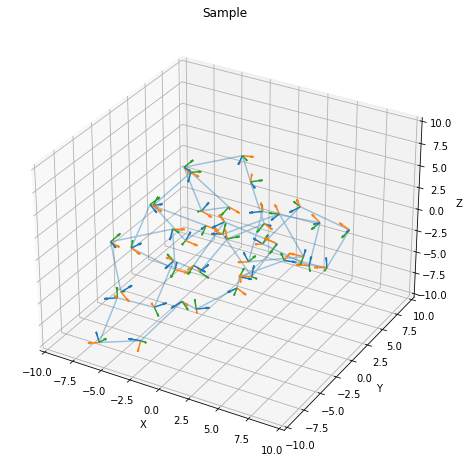

In [54]:
final_rigid = all_steps[-1][0]
f, axes = plt.subplots(1, 1, figsize=[8, 8], subplot_kw=dict(projection="3d"))
viz_frames(final_rigid, res_mask, axes, title='Sample', scale_factor=conf.data.rosetta.scale_factor)

In [59]:
def compute_fape(pred_frame, target_frame, mask, length_scale=1.0):
    pred_frame = ru.Rigid.from_tensor_7(pred_frame)
    target_frame = ru.Rigid.from_tensor_7(target_frame)
    return loss.bb_fape_loss(
        pred_frames=pred_frame,
        target_frames=target_frame,
        frames_mask=mask,
        positions_mask=mask,
        pred_positions=pred_frame.get_trans(),
        target_positions=target_frame.get_trans(),
        l1_clamp_distance=10.0,
        length_scale=length_scale,
        eps=1e-4,
        ignore_nan=True,
    )

In [62]:
compute_fape(final_rigid, rigids_0.to(final_rigid.device), res_mask.to(final_rigid.device))

tensor(0.2081, device='cuda:0', dtype=torch.float64)